In [1]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import torch
from torchinfo import summary
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.transforms as T
import os
from PIL import Image
import numpy as np

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
model = smp.Unet('resnet34', classes=3, activation='softmax').to(device)

In [5]:
summary(model)

Layer (type:depth-idx)                        Param #
Unet                                          --
├─ResNetEncoder: 1-1                          --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    │    └─BasicBlock: 3-3                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-4                   230,144
│    │    └─BasicBlock: 3-5                   295,424
│    │    └─BasicBlock: 3-6                   295,424
│    │    └─BasicBlock: 3-7                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-8                   919,040
│    │    └─BasicBlock: 3-9                   1,180,672
│    │    └─Basi

In [6]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [7]:
loss_fn = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters()},
    {'params': model.segmentation_head.parameters()}
], lr=1e-4)

In [8]:
mask_dir = os.path.join(os.getcwd(),"labels/final_labels")
image_dir= os.path.join(os.getcwd(),"images_224_rename")

In [9]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_filenames = sorted(os.listdir(mask_dir)) 

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])
        
        image = Image.open(image_path.replace(".png", ".jpg")).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # one channel

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [10]:
image_transform = T.Compose([
    T.ToTensor(),  # [0,1] 
    T.Normalize(mean=[0.485, 0.456, 0.406],  
                std=[0.229, 0.224, 0.225])
])

In [11]:
# 轉換 mask 成 tensor
mask_transform = T.Compose([
    T.PILToTensor(),
    T.Lambda(lambda x: x.squeeze().long())
])


In [12]:
# 建立 Dataset
dataset = SegmentationDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=image_transform,
    mask_transform = mask_transform
)

In [13]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [14]:
for imgs, masks in dataloader:
    print(imgs.shape, masks.shape)

torch.Size([4, 3, 224, 224]) torch.Size([4, 224, 224])
torch.Size([4, 3, 224, 224]) torch.Size([4, 224, 224])
torch.Size([4, 3, 224, 224]) torch.Size([4, 224, 224])
torch.Size([2, 3, 224, 224]) torch.Size([2, 224, 224])


In [15]:
def pixel_accuracy(preds, masks):
    """
    preds: prediction, shape = (B, H, W)
    masks: ground truth mask，shape = (B, H, W)
    """
    correct = (preds == masks).float()
    acc = correct.sum() / correct.numel()
    return acc

In [16]:
model.train()
for epoch in range(10):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs = imgs.to(device)
        masks = masks.long().squeeze(1).to(device)  

        outputs = model(imgs)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    with torch.inference_mode():
        val_loss = 0
        val_acc = 0
        val_batches = 0
    
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.long().squeeze(1).to(device)
            
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            loss = loss_fn(outputs, masks)
            acc = pixel_accuracy(preds, masks)
    
            val_loss += loss.item()
            val_acc += acc.item()
            val_batches += 1
    
        avg_loss = val_loss / val_batches
        avg_acc = val_acc / val_batches
        print(f"Epoch [{epoch+1}], Accuracy: {avg_acc:.4f}, Loss: {avg_loss:.4f}")

C:\Users\jacky\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1], Accuracy: 0.3575, Loss: 1.0989
Epoch [2], Accuracy: 0.3614, Loss: 1.1205
Epoch [3], Accuracy: 0.4980, Loss: 1.0898
Epoch [4], Accuracy: 0.6535, Loss: 1.0132
Epoch [5], Accuracy: 0.7632, Loss: 0.9415
Epoch [6], Accuracy: 0.8416, Loss: 0.8723
Epoch [7], Accuracy: 0.8930, Loss: 0.8156
Epoch [8], Accuracy: 0.9217, Loss: 0.7756
Epoch [9], Accuracy: 0.9398, Loss: 0.7484
Epoch [10], Accuracy: 0.9570, Loss: 0.7285


In [44]:
from torchvision.utils import save_image

In [45]:
def save_file(idx):
    model.eval()
    save_dir = os.path.join(os.getcwd(),"labels/prediction")
    os.makedirs(save_dir, exist_ok=True)
    

    idx = idx 
    image, mask = dataset[idx]
    filename = dataset.image_filenames[idx]
    
    image_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1) 

    pred_np = pred.squeeze().cpu().numpy().astype(np.uint8)
    pred_img = Image.fromarray(pred_np, mode='L')  
    
    # save path
    save_path = os.path.join(save_dir, filename)
    pred_img.save(save_path)


In [46]:
# save_file(0)

In [23]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF

def visualize_simple(image, pred_mask, true_mask, class_colors):
    """
    Visualize the original image, prediction, and ground truth using Matplotlib

    Args:
        image (Tensor): Original image (C, H, W)
        pred_mask (Tensor): Prediction mask (H, W)
        true_mask (Tensor): Ground truth mask (H, W)
        class_colors (dict): RGB colors for each class
    """
    # Convert to numpy arrays
    image_np = TF.to_pil_image(image.cpu()).convert("RGB")
    pred_np = pred_mask.squeeze().cpu().numpy()
    true_np = true_mask.squeeze().cpu().numpy()

    # Map to color images
    pred_colored = mask_to_color(pred_np, class_colors)
    true_colored = mask_to_color(true_np, class_colors)

    # Plotting
    plt.figure(figsize=(12, 8))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(true_colored)
    plt.title("Ground Truth")
    plt.axis("off")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pred_colored)
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def mask_to_color(mask, class_colors):
    """
    Convert a mask (H, W) to a color image using the provided class_colors

    Args:
        mask (ndarray): Mask (H, W)
        class_colors (dict): RGB colors for each class
    """
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        color_mask[mask == class_idx] = color
    return color_mask

In [24]:
def showCompare(index):
    image, label = dataset[index]
    image = image.to(device).unsqueeze(0)
    
    # predict
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1)
    
    
    
    
    
    
    # define class color
    class_colors = {
        0: (0, 0, 0),       # background - black
        1: (255, 0, 0),     # pathogen - red
        2: (0, 255, 0),     # petri dish - green
    }
    
    # visualize
    visualize_simple(image.squeeze(0), pred.squeeze(0), label, class_colors)


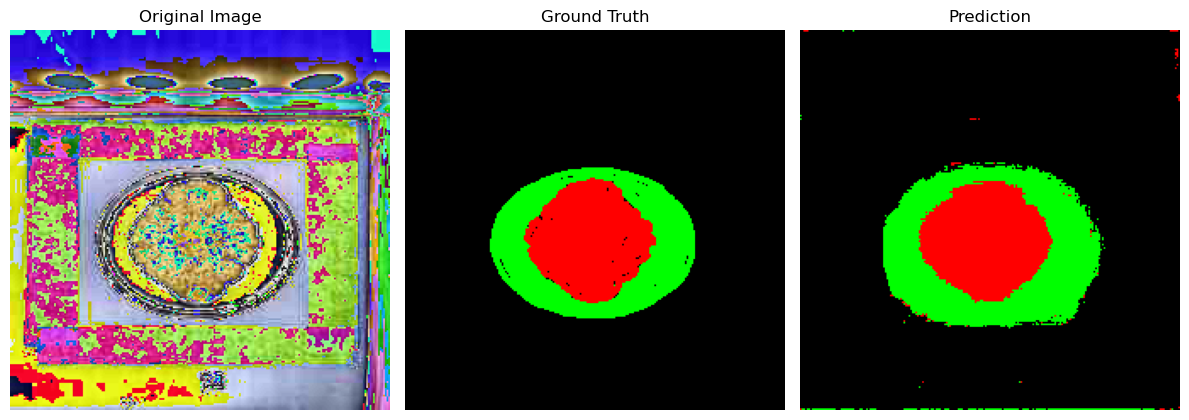

In [25]:
showCompare(1)